In [5]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()
from sklearn.utils.class_weight import compute_class_weight

from data_manipulation.reading_util import load_ml_data_emb

# Reading in esm2 embeddings

### Creating X and y
#### Reading in data (splitX.csv and esm2_splitX)

In [6]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

X, y = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)
print(len(y))
print(len(X))

LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.049 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204
9204
9204


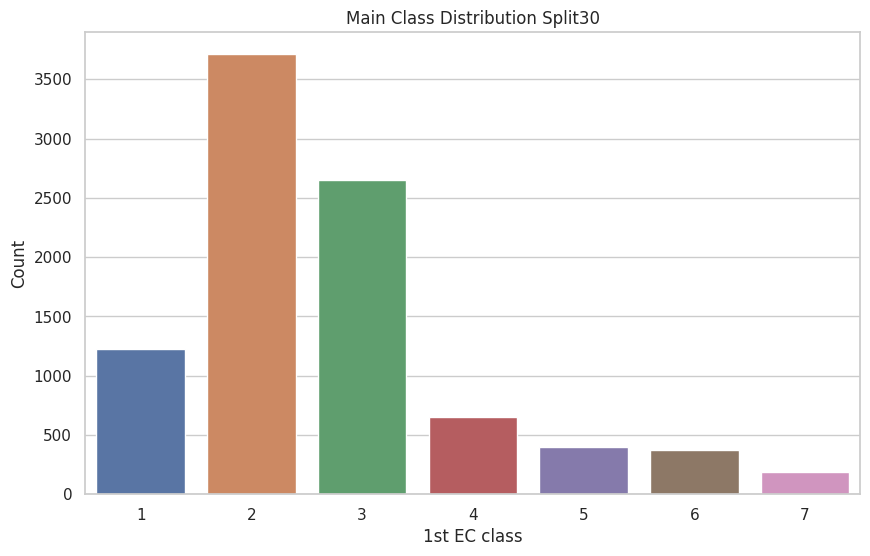

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("1st EC class")
plt.ylabel("Count")
plt.title("Main Class Distribution Split30")

# Show the plot
plt.show()

## Creating and training our CNN

### Splitting data into train and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)
print(y_test_encoded[0])

[0. 0. 1. 0. 0. 0. 0.]


In [9]:
# This is used for stopping the training precess in advance, if our model starts to overfit our training data
earl_stop = tf.keras.callbacks.EarlyStopping(patience=10)

In [10]:

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)


{0: 1.0688568110170897, 1: 0.3569766153164136, 2: 0.495309856989082, 3: 2.0680577849117174, 4: 3.1516634050880628, 5: 3.4467629748528625, 6: 6.526849037487335}


In [7]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [7]:
# Training the model
model.fit(x=X_train, y=y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop], class_weight=class_weight_dict)

Epoch 1/50
202/202 [==============================] - 3s 13ms/step - loss: 1.4648 - val_loss: 1.2267
Epoch 2/50
202/202 [==============================] - 2s 12ms/step - loss: 1.1503 - val_loss: 0.9301
Epoch 3/50
202/202 [==============================] - 2s 11ms/step - loss: 0.9144 - val_loss: 0.8561
Epoch 4/50
202/202 [==============================] - 2s 11ms/step - loss: 0.8025 - val_loss: 0.7735
Epoch 5/50
202/202 [==============================] - 2s 11ms/step - loss: 0.7325 - val_loss: 0.6976
Epoch 6/50
202/202 [==============================] - 2s 11ms/step - loss: 0.6621 - val_loss: 0.6235
Epoch 7/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5970 - val_loss: 0.6061
Epoch 8/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5586 - val_loss: 0.5670
Epoch 9/50
202/202 [==============================] - 2s 11ms/step - loss: 0.5077 - val_loss: 0.5528
Epoch 10/50
202/202 [==============================] - 2s 11ms/step - loss: 0.4886 - val_lo

In [5]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 128)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=7)

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=25, callbacks=[early_stop], verbose=0, class_weight=class_weight_dict)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [11]:

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)  # You can adjust the number of trials as needed


[I 2023-10-22 00:12:18,955] A new study created in memory with name: no-name-2611756a-312b-4fb2-b275-677f3608f4f2
[I 2023-10-22 00:12:44,917] Trial 0 finished with value: 0.5644661784172058 and parameters: {'num_units_dense_1': 94, 'dropout_rate_1': 0.1861334154797616, 'num_units_dense_2': 255, 'dropout_rate_2': 0.07602365190452073, 'num_units_dense_3': 28}. Best is trial 0 with value: 0.5644661784172058.
[I 2023-10-22 00:13:11,984] Trial 1 finished with value: 0.5470366477966309 and parameters: {'num_units_dense_1': 102, 'dropout_rate_1': 0.42215695069212716, 'num_units_dense_2': 223, 'dropout_rate_2': 0.5614589055830029, 'num_units_dense_3': 76}. Best is trial 1 with value: 0.5470366477966309.
[I 2023-10-22 00:13:34,436] Trial 2 finished with value: 0.6005330085754395 and parameters: {'num_units_dense_1': 67, 'dropout_rate_1': 0.4844262546013307, 'num_units_dense_2': 211, 'dropout_rate_2': 0.2832943977064253, 'num_units_dense_3': 54}. Best is trial 1 with value: 0.5470366477966309.
[

In [11]:

best_params = {'num_units_dense_1': 510, 'dropout_rate_1': 0.6797846248557369, 'num_units_dense_2': 42, 'dropout_rate_2': 0.039440721567988016, 'num_units_dense_3': 118}
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']
best_dropout_rate_2 = best_params['dropout_rate_2']
best_num_units_dense_3 = best_params['num_units_dense_3']


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=7, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=7)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)


{0: 1.0688568110170897, 1: 0.3569766153164136, 2: 0.495309856989082, 3: 2.0680577849117174, 4: 3.1516634050880628, 5: 3.4467629748528625, 6: 6.526849037487335}
Epoch 1/100
202/202 [==============================] - 6s 24ms/step - loss: 1.8176 - accuracy: 0.1768 - val_loss: 1.6822 - val_accuracy: 0.2230
Epoch 2/100
202/202 [==============================] - 4s 20ms/step - loss: 1.4861 - accuracy: 0.3350 - val_loss: 1.2532 - val_accuracy: 0.5199
Epoch 3/100
202/202 [==============================] - 4s 21ms/step - loss: 1.2169 - accuracy: 0.4455 - val_loss: 1.4141 - val_accuracy: 0.4645
Epoch 4/100
202/202 [==============================] - 4s 20ms/step - loss: 1.0472 - accuracy: 0.5250 - val_loss: 1.1148 - val_accuracy: 0.5731
Epoch 5/100
202/202 [==============================] - 4s 20ms/step - loss: 0.9400 - accuracy: 0.5781 - val_loss: 0.9678 - val_accuracy: 0.6640
Epoch 6/100
202/202 [==============================] - 4s 20ms/step - loss: 0.8632 - accuracy: 0.6160 - val_loss: 0.8738

# Evaluation

<Figure size 1000x600 with 0 Axes>

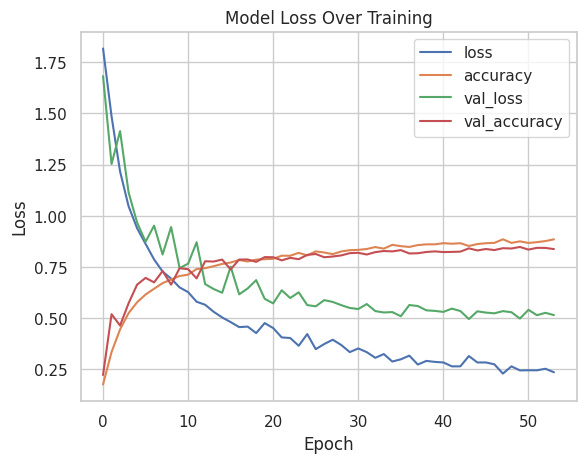

In [13]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
predictions = np.argmax(final_model.predict(X_test), axis=-1) # for multi class classification (using softmax)

87/87 [==============================] - 0s 3ms/step


In [15]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  2314
Total samples predicted: 2762


In [16]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       367
           1       0.93      0.83      0.88      1134
           2       0.87      0.89      0.88       789
           3       0.64      0.69      0.66       203
           4       0.56      0.75      0.65       110
           5       0.74      0.86      0.79       110
           6       0.79      0.69      0.74        49

    accuracy                           0.84      2762
   macro avg       0.76      0.80      0.78      2762
weighted avg       0.85      0.84      0.84      2762


In [12]:
def plot_report(report, y , predictions):
    """
    Plots results of model
    :param report: Report of model
    """
    
    class_0_metrics = report.split('\n')[2].split()[1:]
    class_1_metrics = report.split('\n')[3].split()[1:]
    class_2_metrics = report.split('\n')[4].split()[1:]
    class_3_metrics = report.split('\n')[5].split()[1:]
    class_4_metrics = report.split('\n')[6].split()[1:]
    class_5_metrics = report.split('\n')[7].split()[1:]
    class_6_metrics = report.split('\n')[8].split()[1:]

    metrics = [class_0_metrics,
               class_1_metrics,
               class_2_metrics,
               class_3_metrics,
               class_4_metrics,
               class_5_metrics,
               class_6_metrics
               ]
    
    precs = []
    recs = []
    f1_s = []
    
    for class_m in metrics:
        precision = float(class_m[0])
        recall = float(class_m[1])
        f1_score = float(class_m[2])
        precs.append(precision)
        recs.append(recall)
        f1_s.append(f1_score)

    class_names = [1,2,3,4,5,6,7]

    # Create subplots for accuracy, precision, and F1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot accuracy for each class
    ax1.bar(class_names, recs)
    ax1.set_title("Recall")
    ax1.set_xlabel("Main Class")


    # Plot precision for each class
    ax2.bar(class_names, precs)
    ax2.set_title("Precision")
    ax2.set_xlabel("Main Class")

    # Plot F1 score for each class
    ax3.bar(class_names, f1_s)
    ax3.set_title("F1 Score")
    ax3.set_xlabel("Main Class")

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

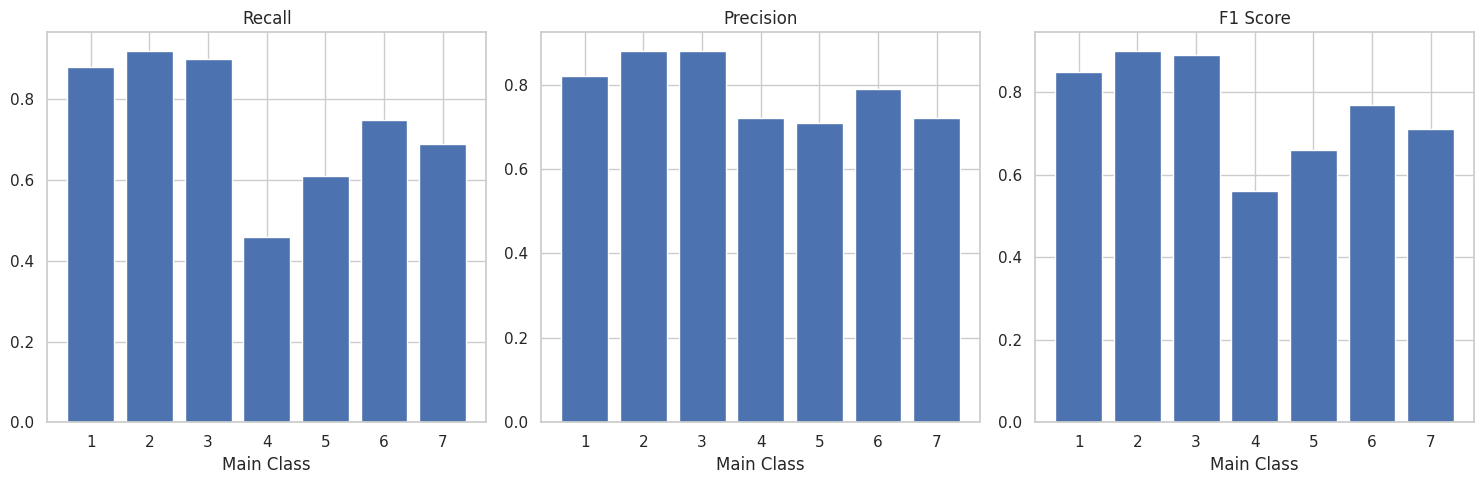

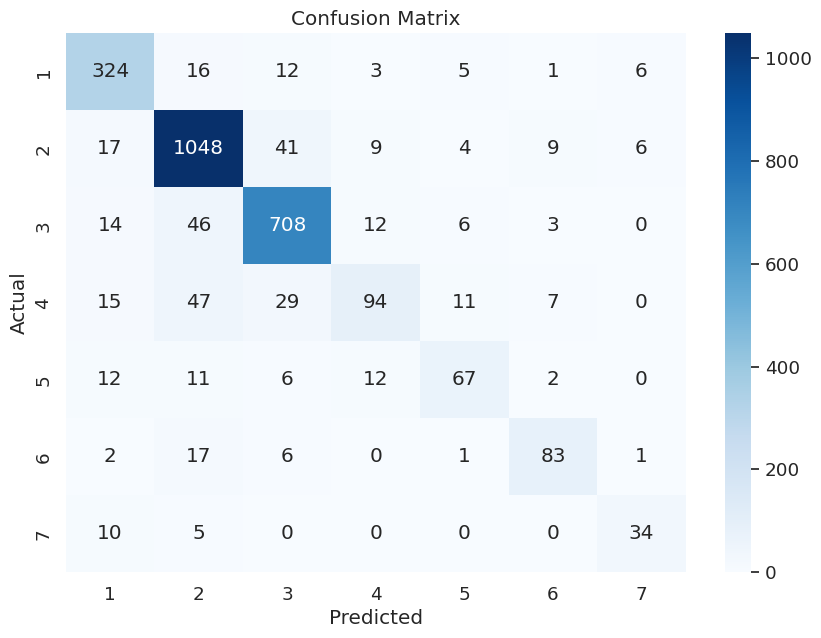

In [13]:
plot_report(report, y_test, predictions)

In [18]:
final_model.save("cnn_S30_opt_weighted_v1.keras")

# Importing and using my model

## 2. Predict new data
The data needs to be the same shape as the training/test data used to train the model.
The unlabeled embeddings need to be imported into a dataframe and then we need to create a feature column for each 
value of the embedding.


In [18]:
def validate_on_test_data(path_to_enzyme_test_csv: str, path_to_enzyme_test_esm2: str, path_to_cnn_model):
    """
    Easy way to test a model on test dataset
    :param path_to_enzyme_test_csv: Path to test.csv
    :param path_to_enzyme_test_esm2: Path to test_esm2.h5
    :param path_to_cnn_model: Path to model of choice
    """
    
    # Load model and test data
    model = tf.keras.models.load_model(path_to_cnn_model)
    
    X, y = load_ml_data_emb(path_to_esm2=path_to_enzyme_test_esm2, path_to_enzyme_csv=path_to_enzyme_test_csv)



    print("\n\n============================================= PREDICTING TEST DATA =============================================\n\n") 
    
    predictions = np.argmax(model.predict(X), axis=-1) # for multi class classification (using softmax)
   
    print("LOG: Making predictions: DONE")
    
    # Evaluation
    counter = 0
    for label, predict_label in zip(y,predictions):
        if label == predict_label:
            counter+=1
            
    print("LOG: Correct predictions: ", counter)
    print("LOG: Total samples predicted:", len(y))
    print("\n\n\n")


    report = classification_report(y, predictions)
    
    print(report)
    
    plot_report(report, y, predictions)


    # Overview of class dist
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.countplot(x=y, palette="Set3")

    plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
    plt.xlabel("EC class")
    plt.ylabel("Count")
    plt.title("Main Class Distribution")

    plt.show()



Data loaded in: 0.811 min


============================================= PREDICTING TEST DATA =============================================


226/226 [==============================] - 1s 2ms/step
LOG: Making predictions: DONE
LOG: Correct predictions:  6869
LOG: Total samples predicted: 7212
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       894
           1       0.96      0.98      0.97      2952
           2       0.97      0.96      0.96      2149
           3       0.90      0.82      0.86       515
           4       0.92      0.88      0.90       304
           5       0.96      0.93      0.94       233
           6       0.99      0.96      0.97       165

    accuracy                           0.95      7212
   macro avg       0.95      0.93      0.94      7212
weighted avg       0.95      0.95      0.95      7212


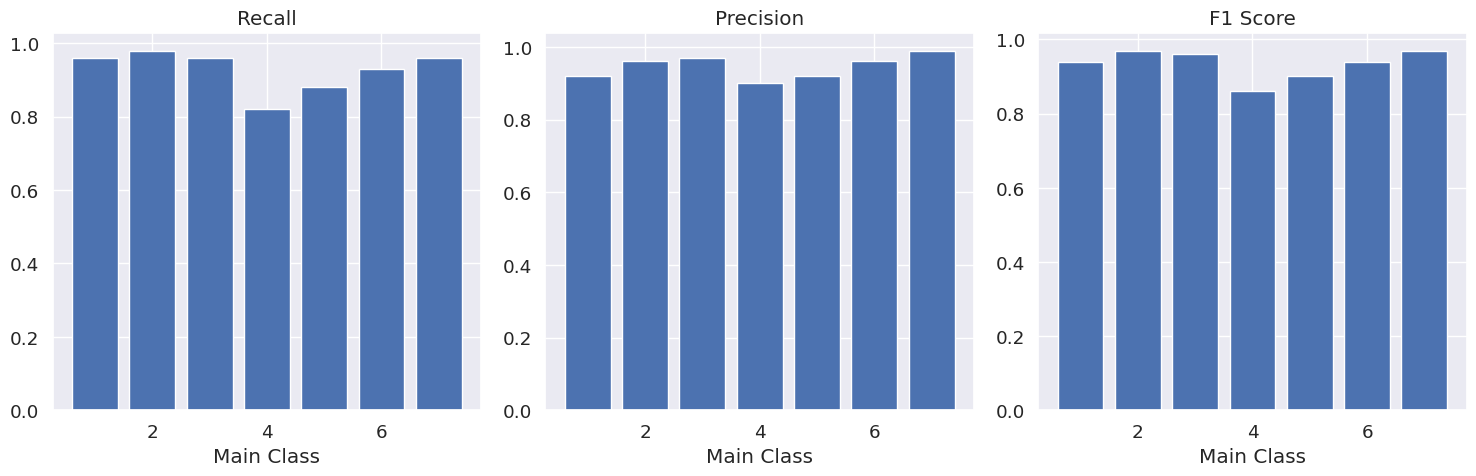

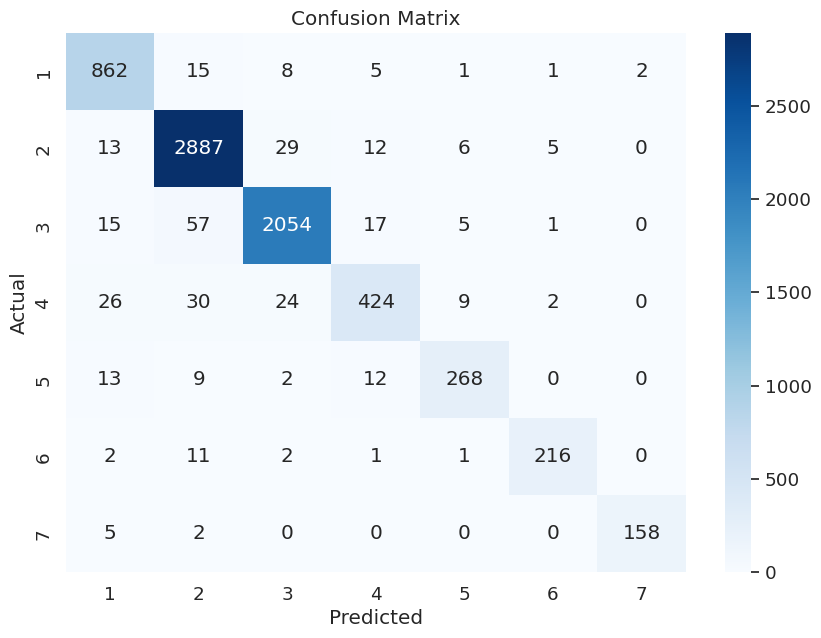

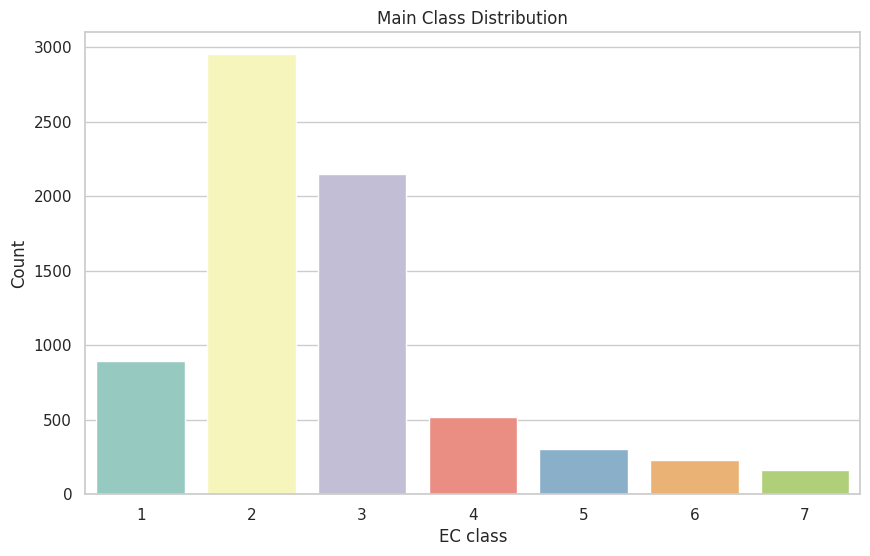

In [19]:
validate_on_test_data(path_to_enzyme_test_csv=os.getenv("CSV10_ENZYMES"),
                      path_to_enzyme_test_esm2=os.getenv("ESM2_ENZYMES_SPLIT_10"),
                      path_to_cnn_model="/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/cnn_v5_1_split100.keras")

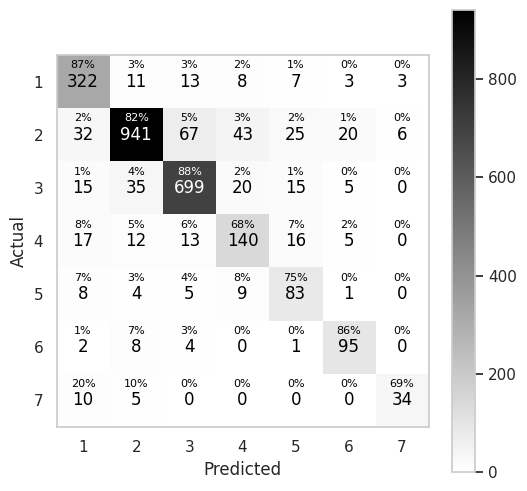

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = [1,2,3,4,5,6,7]
conf_matrix = confusion_matrix(y_val, predictions)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(7):
    for j in range(7):

        # Increase the vertical offset for the percentage text
        offset = 0.4
        text_color = cax.texts[i * 7 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=8, fontweight='light', zorder=4)


# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)

plt.show()


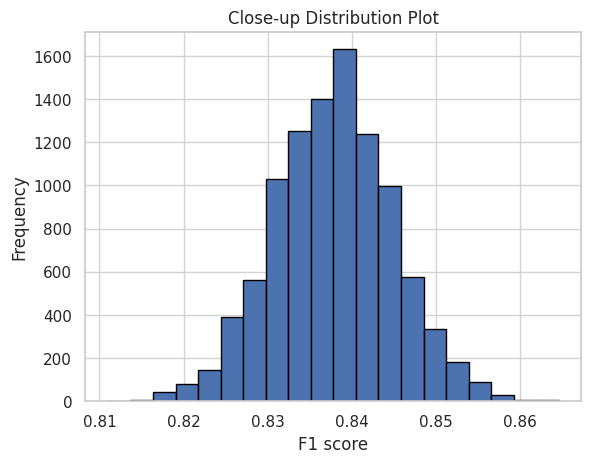

Multiclass CNN:
  - Initial F1 Score: 0.84
  - Mean ± SE: 0.838 ± 0.007
  - 95% CI: [0.82, 0.85]


In [26]:
import math
from sklearn.metrics import f1_score


def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.80
    max_value = 0.87

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels
    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)


def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)


def train_and_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


initial_f1 = calculate_f1(y_val, predictions)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_val, predictions, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
